In [31]:
import os
import cv2
import numpy as np
from scipy import ndimage
from scipy.signal import convolve2d
from tqdm import tqdm
import matplotlib.pyplot as plt
from utils.imgutils import *
from utils.functions import *
from utils.pairs import *

In [32]:
filename = '../project_github/IrisRecognition/CASIA1/1/001_1_1.jpg'
img = cv2.imread(filename, 0)
print(img.shape)

# Params
eyelashes_threshold = 80
radial_resolution = 20
angular_resolution = 240    
minw_length = 18
mult = 1
sigma_f = 0.5

# Three step pipeline - Segmentation, normalization, feature encoding
# Segmentation
ciriris, cirpupil, imwithnoise = segment(img, 80, False)

# Normalization
arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                    cirpupil[1], cirpupil[0], cirpupil[2],
                                    radial_resolution, angular_resolution)

# Feature encoding
template, mask_noise = encode_iris(arr_polar, arr_noise, minw_length, mult, sigma_f)

(280, 320)


In [33]:
def encode_features(filename, eyelashes_threshold = 80):
    # Parameters
    eyelashes_threshold = 80
    radial_resolution = 20
    angular_resolution = 240
    minw_length = 18
    mult = 1
    sigma_f = 0.5
    multiprocess = False
    #  segmentation
    im = imread(filename, 0)
    ciriris, cirpupil, imwithnoise = segment(im, eyelashes_threshold,
                                    multiprocess)

    # normalization
    arr_polar, arr_noise = normalize(imwithnoise, ciriris[1],  ciriris[0], ciriris[2],
                                         cirpupil[1], cirpupil[0], cirpupil[2],
                                         radial_resolution, angular_resolution)

    #  feature encoding
    template, mask_noise = encode_iris(arr_polar, arr_noise, minw_length, mult,
    sigma_f)
    

    return template, mask_noise, filename



In [34]:
def extract_and_store(filenames_list, output_dir = 'features'):
    os.makedirs(output_dir, exist_ok = True)
    print(f"\nExtracting and storing features in '{output_dir}'...")

    for img_filename in tqdm(filenames_list, desc="Processing images"):
        template, mask, original_path = encode_features(img_filename)

        if template is not None and mask is not None:
            # Create a unique filename for the template and mask
            # For example, 'IITD/001/01_L.bmp' becomes 'features/001_01_L.npy'
            relative_path = os.path.relpath(original_path, start='IITD')
            base_name = os.path.splitext(relative_path)[0].replace(os.sep, '_')
            
            template_filename = os.path.join(output_dir, f'{base_name}_template.npy')
            mask_filename = os.path.join(output_dir, f'{base_name}_mask.npy')

            # Save the numpy arrays to disk
            np.save(template_filename, template)
            np.save(mask_filename, mask)


In [35]:
# Run for all the files in the dataset -
def pipeline(extract = False):
    dataset_path = '../datasets/IITD'

    all_filenames = get_filenames(dataset_path)
    print(f"Found {len(all_filenames)} .bmp files")

    structured_data = get_users(all_filenames)
    if structured_data:
        print(f"Successfully organized data for {len(structured_data)} users.")
    else:
        print("Could not find any user data. Please check the 'dataset_path'.")

    
    print(all_filenames[0])
    if (extract):
        extract_and_store(all_filenames)
    print("\nFeature extraction and storage complete.")

    return all_filenames, structured_data
    

In [36]:
all_filenames, structured_data = pipeline()

Found 2240 .bmp files
Organizaing users for 2240 files
Successfully organized data for 224 users.
../datasets/IITD/196/09_R.bmp

Feature extraction and storage complete.


In [37]:
def load_template_and_mask(image_path, features_dir='features'):
    """
    Loads a template and mask based on the original image path,
    now correctly handling your specific file naming convention.
    """
    try:
        # Step 1: Get the full path to the image, relative to the current working directory
        full_image_path_norm = os.path.normpath(image_path)
        
        # Step 2: Get the filename part and the path part without the extension
        path_without_ext, _ = os.path.splitext(full_image_path_norm)
        
        # Step 3: Recreate the base name string by replacing path separators
        # This matches the pattern '.._.._datasets_IITD_...'
        base_name = path_without_ext.replace(os.sep, '_').replace('..', '.._..')
        
        # Step 4: Construct the full path to the feature files
        template_filename = os.path.join(features_dir, f'{base_name}_template.npy')
        mask_filename = os.path.join(features_dir, f'{base_name}_mask.npy')
        
        # Print the path for debugging to ensure it's correct
        #print(f"Loading files from: {template_filename}")
        
        template = np.load(template_filename)
        mask = np.load(mask_filename)
        return template, mask
    except FileNotFoundError:
        print(f"Error: Template or mask not found for {image_path}.")
        print(f"Looked for: '{template_filename}'")
        return None, None
    except Exception as e:
        print(f"An error occurred loading features for {image_path}: {e}")
        return None, None

def compare_pairs(pairs_list, features_dir='features', is_genuine=True):
    """
    Calculates and returns the list of Hamming distances for a given list of pairs.
    """
    distances = []
    pair_type = "Genuine" if is_genuine else "Impostor"
    
    print(f"\nCalculating Hamming distances for {len(pairs_list)} {pair_type.lower()} pairs...")
    
    for pair in tqdm(pairs_list, desc=f"Comparing {pair_type} pairs"):
        img_path1, img_path2 = pair
        
        template1, mask1 = load_template_and_mask(img_path1, features_dir)
        template2, mask2 = load_template_and_mask(img_path2, features_dir)

        if template1 is not None and template2 is not None:
            distance = HammingDistance(template1, mask1, template2, mask2)
            if not np.isnan(distance):
                distances.append(distance)
    
    return distances

def plot_distributions(genuine_distances, impostor_distances):
    """
    Creates and displays a histogram of the genuine and impostor Hamming distances.
    """
    plt.figure(figsize=(10, 6))
    plt.hist(genuine_distances, bins=50, alpha=0.5, label='Genuine Pairs')
    plt.hist(impostor_distances, bins=50, alpha=0.5, label='Impostor Pairs')
    
    plt.title('Distribution of Hamming Distances')
    plt.xlabel('Hamming Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()

In [38]:
def test( all_filenames, structured_data, features_path = './features'):
    # Generate genuine pairs
    genuine_pairs = generate_genuine_pairs(structured_data)
    print(f"\n--- Pair Generation Summary ---")
    print(f"Found {len(genuine_pairs)} genuine pairs.")

    num_impostor_pairs_to_generate = len(genuine_pairs)
    impostor_pairs = generate_impostor_pairs(structured_data, num_impostor_pairs_to_generate)
    print(f"Generated {len(impostor_pairs)} impostor pairs.")
    

    print("\n--- Example Pairs ---")
    if genuine_pairs:
        print("Genuine Pair Example:")
        print(f"  {genuine_pairs[0]}")
    if impostor_pairs:
        print("Impostor Pair Example:")
        print(f"  {impostor_pairs[0]}")
    genuine_distances = compare_pairs(genuine_pairs, features_path, is_genuine=True)
    impostor_distances = compare_pairs(impostor_pairs, features_path, is_genuine=False)

     # Step 3: Plot the distributions
    if genuine_distances and impostor_distances:
        plot_distributions(genuine_distances, impostor_distances)
    else:
        print("\nCould not generate the plot. Please check if the 'features' directory exists and contains data.")


Generated - 4808 genuine pairs

--- Pair Generation Summary ---
Found 4808 genuine pairs.
Generating 4808 impostor pairs...
Generated 4808 impostor pairs.

--- Example Pairs ---
Genuine Pair Example:
  ('../datasets/IITD/196/09_R.bmp', '../datasets/IITD/196/10_R.bmp')
Impostor Pair Example:
  ('../datasets/IITD/148/07_R.bmp', '../datasets/IITD/192/10_R.bmp')

Calculating Hamming distances for 4808 genuine pairs...


Comparing Genuine pairs:   2%|▏         | 82/4808 [00:00<00:05, 811.18it/s]

Loading files from: ./features/.._.._datasets_IITD_196_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Loading files from: ./features/.._.._datasets_IITD_097_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_042_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:   5%|▌         | 246/4808 [00:00<00:05, 815.73it/s]

Loading files from: ./features/.._.._datasets_IITD_033_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:   7%|▋         | 329/4808 [00:00<00:05, 819.69it/s]

Loading files from: ./features/.._.._datasets_IITD_031_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:   9%|▊         | 411/4808 [00:00<00:05, 818.84it/s]

Loading files from: ./features/.._.._datasets_IITD_081_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  12%|█▏        | 576/4808 [00:00<00:05, 816.08it/s]

Loading files from: ./features/.._.._datasets_IITD_087_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_087_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  15%|█▌        | 742/4808 [00:00<00:04, 819.46it/s]

Loading files from: ./features/.._.._datasets_IITD_017_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_017_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  19%|█▉        | 907/4808 [00:01<00:04, 820.64it/s]

Loading files from: ./features/.._.._datasets_IITD_012_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_012_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  22%|██▏       | 1073/4808 [00:01<00:04, 821.18it/s]

Loading files from: ./features/.._.._datasets_IITD_020_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  26%|██▌       | 1238/4808 [00:01<00:04, 818.67it/s]

Loading files from: ./features/.._.._datasets_IITD_220_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  29%|██▉       | 1402/4808 [00:01<00:04, 802.56it/s]

Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  32%|███▏      | 1562/4808 [00:01<00:04, 775.05it/s]

Loading files from: ./features/.._.._datasets_IITD_150_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_206_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  36%|███▌      | 1719/4808 [00:02<00:03, 774.72it/s]

Loading files from: ./features/.._.._datasets_IITD_021_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  39%|███▉      | 1874/4808 [00:02<00:03, 763.69it/s]

Loading files from: ./features/.._.._datasets_IITD_207_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  42%|████▏     | 2032/4808 [00:02<00:03, 777.13it/s]

Loading files from: ./features/.._.._datasets_IITD_049_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  46%|████▌     | 2195/4808 [00:02<00:03, 794.84it/s]

Loading files from: ./features/.._.._datasets_IITD_173_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  49%|████▉     | 2359/4808 [00:02<00:03, 803.57it/s]

Loading files from: ./features/.._.._datasets_IITD_188_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  52%|█████▏    | 2523/4808 [00:03<00:02, 808.51it/s]

Loading files from: ./features/.._.._datasets_IITD_125_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  56%|█████▌    | 2687/4808 [00:03<00:02, 810.36it/s]

Loading files from: ./features/.._.._datasets_IITD_135_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  59%|█████▉    | 2850/4808 [00:03<00:02, 802.13it/s]

Loading files from: ./features/.._.._datasets_IITD_127_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  63%|██████▎   | 3012/4808 [00:03<00:02, 793.92it/s]

Loading files from: ./features/.._.._datasets_IITD_214_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  66%|██████▌   | 3172/4808 [00:03<00:02, 796.13it/s]

Loading files from: ./features/.._.._datasets_IITD_076_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  69%|██████▉   | 3334/4808 [00:04<00:01, 802.44it/s]

Loading files from: ./features/.._.._datasets_IITD_167_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  73%|███████▎  | 3500/4808 [00:04<00:01, 813.95it/s]

Loading files from: ./features/.._.._datasets_IITD_014_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  75%|███████▍  | 3582/4808 [00:04<00:01, 811.89it/s]

Loading files from: ./features/.._.._datasets_IITD_002_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  76%|███████▌  | 3665/4808 [00:04<00:01, 814.49it/s]

Loading files from: ./features/.._.._datasets_IITD_162_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  78%|███████▊  | 3747/4808 [00:04<00:01, 809.77it/s]

Loading files from: ./features/.._.._datasets_IITD_153_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  80%|███████▉  | 3828/4808 [00:04<00:01, 806.96it/s]

Loading files from: ./features/.._.._datasets_IITD_041_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  81%|████████▏ | 3911/4808 [00:04<00:01, 811.67it/s]

Loading files from: ./features/.._.._datasets_IITD_088_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  83%|████████▎ | 3993/4808 [00:04<00:01, 807.57it/s]

Loading files from: ./features/.._.._datasets_IITD_194_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  85%|████████▍ | 4074/4808 [00:05<00:00, 800.13it/s]

Loading files from: ./features/.._.._datasets_IITD_009_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  86%|████████▋ | 4156/4808 [00:05<00:00, 805.61it/s]

Loading files from: ./features/.._.._datasets_IITD_199_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_199_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  88%|████████▊ | 4238/4808 [00:05<00:00, 807.38it/s]

Loading files from: ./features/.._.._datasets_IITD_013_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  90%|████████▉ | 4322/4808 [00:05<00:00, 815.39it/s]

Loading files from: ./features/.._.._datasets_IITD_006_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_006_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  92%|█████████▏| 4404/4808 [00:05<00:00, 813.98it/s]

Loading files from: ./features/.._.._datasets_IITD_056_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  93%|█████████▎| 4486/4808 [00:05<00:00, 814.33it/s]

Loading files from: ./features/.._.._datasets_IITD_136_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_136_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  95%|█████████▌| 4568/4808 [00:05<00:00, 811.52it/s]

Loading files from: ./features/.._.._datasets_IITD_177_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs:  97%|█████████▋| 4651/4808 [00:05<00:00, 815.70it/s]

Loading files from: ./features/.._.._datasets_IITD_018_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Genuine pairs: 100%|██████████| 4808/4808 [00:05<00:00, 804.41it/s]


Loading files from: ./features/.._.._datasets_IITD_191_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   0%|          | 0/4808 [00:00<?, ?it/s]

Loading files from: ./features/.._.._datasets_IITD_148_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_095_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_067_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_124_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_063_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_189_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_042_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_131_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   2%|▏         | 77/4808 [00:00<00:06, 769.00it/s]

Loading files from: ./features/.._.._datasets_IITD_083_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_139_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_005_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_195_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_133_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_045_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_206_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_059_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_216_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_091_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_193_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_025_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   3%|▎         | 156/4808 [00:00<00:06, 774.86it/s]

Loading files from: ./features/.._.._datasets_IITD_012_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_119_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_082_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_139_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_055_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_012_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_048_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_051_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_113_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   5%|▍         | 234/4808 [00:00<00:05, 764.71it/s]

Loading files from: ./features/.._.._datasets_IITD_115_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_113_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_116_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_078_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_047_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_161_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_080_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_008_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_034_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   7%|▋         | 313/4808 [00:00<00:05, 772.92it/s]

Loading files from: ./features/.._.._datasets_IITD_006_09_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_109_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_172_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_143_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_063_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_223_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_045_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_098_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:   8%|▊         | 392/4808 [00:00<00:05, 778.44it/s]

Loading files from: ./features/.._.._datasets_IITD_049_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_093_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_023_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_012_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_062_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_115_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_204_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_054_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_106_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  10%|▉         | 473/4808 [00:00<00:05, 788.19it/s]

Loading files from: ./features/.._.._datasets_IITD_131_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_133_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_158_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_210_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_050_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_213_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_084_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_176_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_079_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_216_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_112_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  12%|█▏        | 554/4808 [00:00<00:05, 794.09it/s]

Loading files from: ./features/.._.._datasets_IITD_075_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_003_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_120_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_175_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_114_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_136_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_103_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_204_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_154_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_119_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  13%|█▎        | 637/4808 [00:00<00:05, 802.83it/s]

Loading files from: ./features/.._.._datasets_IITD_028_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_065_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_101_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_195_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_055_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_195_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_215_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_170_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_093_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  15%|█▍        | 718/4808 [00:00<00:05, 804.14it/s]

Loading files from: ./features/.._.._datasets_IITD_089_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_053_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_086_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_010_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_151_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_004_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_193_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_210_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_001_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_064_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_079_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  17%|█▋        | 800/4808 [00:01<00:04, 807.27it/s]

Loading files from: ./features/.._.._datasets_IITD_013_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_218_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_050_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_029_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_067_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_136_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_004_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_125_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_158_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_171_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_164_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  18%|█▊        | 881/4808 [00:01<00:04, 802.40it/s]

Loading files from: ./features/.._.._datasets_IITD_059_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_124_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_219_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_005_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_043_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_169_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  20%|██        | 962/4808 [00:01<00:04, 794.28it/s]

Loading files from: ./features/.._.._datasets_IITD_131_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_161_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_052_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_171_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_030_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_068_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_198_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_086_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_107_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_164_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  22%|██▏       | 1042/4808 [00:01<00:04, 794.02it/s]

Loading files from: ./features/.._.._datasets_IITD_031_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_117_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_184_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_052_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_155_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_166_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_112_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_075_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_203_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  23%|██▎       | 1125/4808 [00:01<00:04, 803.30it/s]

Loading files from: ./features/.._.._datasets_IITD_069_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_187_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_025_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_119_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_151_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_218_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_197_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_018_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_032_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_112_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_221_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  25%|██▌       | 1206/4808 [00:01<00:04, 798.63it/s]

Loading files from: ./features/.._.._datasets_IITD_005_09_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_100_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_106_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_127_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_089_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_223_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_147_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_180_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_099_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_138_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  27%|██▋       | 1288/4808 [00:01<00:04, 802.06it/s]

Loading files from: ./features/.._.._datasets_IITD_067_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_007_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_166_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_045_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_101_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_142_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_055_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_204_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_164_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  28%|██▊       | 1369/4808 [00:01<00:04, 797.59it/s]

Loading files from: ./features/.._.._datasets_IITD_128_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_029_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_030_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_112_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_030_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_043_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_073_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_133_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  30%|███       | 1449/4808 [00:01<00:04, 793.93it/s]

Loading files from: ./features/.._.._datasets_IITD_098_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_113_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_091_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_023_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_029_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_034_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_106_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_109_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_175_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_071_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  32%|███▏      | 1530/4808 [00:01<00:04, 796.67it/s]

Loading files from: ./features/.._.._datasets_IITD_080_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_083_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_155_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_017_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_224_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_034_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_072_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_206_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  33%|███▎      | 1610/4808 [00:02<00:04, 790.59it/s]

Loading files from: ./features/.._.._datasets_IITD_014_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_085_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_145_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_038_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_107_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_010_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_217_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_012_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_152_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  35%|███▌      | 1692/4808 [00:02<00:03, 797.07it/s]

Loading files from: ./features/.._.._datasets_IITD_010_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_075_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_178_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_085_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_096_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_052_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_056_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_097_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_211_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  37%|███▋      | 1772/4808 [00:02<00:03, 791.47it/s]

Loading files from: ./features/.._.._datasets_IITD_102_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_184_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_068_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_193_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_075_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_166_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_076_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_111_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_105_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_169_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_067_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_176_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_065_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  39%|███▊      | 1852/4808 [00:02<00:03, 790.54it/s]

Loading files from: ./features/.._.._datasets_IITD_079_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_085_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_181_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_203_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_099_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_143_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_019_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_089_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_157_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  40%|████      | 1932/4808 [00:02<00:03, 791.10it/s]

Loading files from: ./features/.._.._datasets_IITD_023_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_115_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_176_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_137_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_223_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_203_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_104_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_222_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_106_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  42%|████▏     | 2012/4808 [00:02<00:03, 791.90it/s]

Loading files from: ./features/.._.._datasets_IITD_069_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_179_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_187_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_215_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_137_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_158_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_008_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_152_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  44%|████▎     | 2092/4808 [00:02<00:03, 792.91it/s]

Loading files from: ./features/.._.._datasets_IITD_065_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_184_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_171_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_174_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_016_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_003_08_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_159_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_137_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  45%|████▌     | 2172/4808 [00:02<00:03, 790.27it/s]

Loading files from: ./features/.._.._datasets_IITD_040_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_205_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_034_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_063_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_025_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_027_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_111_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_128_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_183_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_216_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_157_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_215_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  47%|████▋     | 2252/4808 [00:02<00:03, 786.58it/s]

Loading files from: ./features/.._.._datasets_IITD_011_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_216_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_145_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_170_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_140_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_132_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_145_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_108_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_204_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_001_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  49%|████▊     | 2332/4808 [00:02<00:03, 787.81it/s]

Loading files from: ./features/.._.._datasets_IITD_026_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_116_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_027_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_043_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_198_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_123_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_158_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_172_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_138_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  50%|█████     | 2412/4808 [00:03<00:03, 789.96it/s]

Loading files from: ./features/.._.._datasets_IITD_119_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_134_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_034_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_040_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_141_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_051_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_201_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_116_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_179_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_124_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  52%|█████▏    | 2492/4808 [00:03<00:02, 791.03it/s]

Loading files from: ./features/.._.._datasets_IITD_016_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_072_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_216_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_183_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_082_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_102_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_001_10_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_084_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_103_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_139_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  53%|█████▎    | 2572/4808 [00:03<00:02, 791.21it/s]

Loading files from: ./features/.._.._datasets_IITD_200_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_023_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_026_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_176_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_187_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_101_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_134_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_103_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_168_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  55%|█████▌    | 2652/4808 [00:03<00:02, 790.03it/s]

Loading files from: ./features/.._.._datasets_IITD_095_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_109_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_160_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_199_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_042_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_131_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_175_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_043_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_211_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_016_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_217_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  57%|█████▋    | 2732/4808 [00:03<00:02, 785.95it/s]

Loading files from: ./features/.._.._datasets_IITD_054_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_174_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_095_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_147_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_185_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_201_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_113_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_086_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_206_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  58%|█████▊    | 2811/4808 [00:03<00:02, 786.75it/s]

Loading files from: ./features/.._.._datasets_IITD_192_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_089_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_029_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_152_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_051_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_052_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_058_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_073_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  60%|██████    | 2890/4808 [00:03<00:02, 787.33it/s]

Loading files from: ./features/.._.._datasets_IITD_142_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_195_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_064_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_143_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_027_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_150_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_189_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_162_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_224_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_052_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_194_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_133_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  62%|██████▏   | 2972/4808 [00:03<00:02, 794.55it/s]

Loading files from: ./features/.._.._datasets_IITD_144_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_157_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_024_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_063_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_005_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_224_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_042_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_065_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_038_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_137_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  63%|██████▎   | 3052/4808 [00:03<00:02, 794.54it/s]

Loading files from: ./features/.._.._datasets_IITD_047_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_190_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_217_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_051_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_170_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_198_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_107_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_198_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_093_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  65%|██████▌   | 3132/4808 [00:03<00:02, 783.85it/s]

Loading files from: ./features/.._.._datasets_IITD_184_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_206_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_046_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_137_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_163_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_210_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_182_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_060_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_107_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_171_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  67%|██████▋   | 3211/4808 [00:04<00:02, 774.50it/s]

Loading files from: ./features/.._.._datasets_IITD_087_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_024_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_077_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_060_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_114_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_062_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_115_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_120_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_008_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  68%|██████▊   | 3290/4808 [00:04<00:01, 777.55it/s]

Loading files from: ./features/.._.._datasets_IITD_012_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_144_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_219_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_015_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_040_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_138_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_089_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_008_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_025_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  70%|███████   | 3368/4808 [00:04<00:01, 777.53it/s]

Loading files from: ./features/.._.._datasets_IITD_181_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_219_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_055_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_104_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_046_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_221_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_181_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_014_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_086_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_105_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_028_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  72%|███████▏  | 3446/4808 [00:04<00:01, 769.62it/s]

Loading files from: ./features/.._.._datasets_IITD_062_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_079_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_207_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_151_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_203_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_210_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_013_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_172_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_047_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_123_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  73%|███████▎  | 3525/4808 [00:04<00:01, 773.41it/s]

Loading files from: ./features/.._.._datasets_IITD_146_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_165_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_189_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_101_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_218_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_017_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_221_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_042_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_120_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_045_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_120_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_168_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  75%|███████▍  | 3604/4808 [00:04<00:01, 778.26it/s]

Loading files from: ./features/.._.._datasets_IITD_087_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_157_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_028_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_106_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_104_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_117_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_017_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_142_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_201_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_098_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_186_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_054_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  77%|███████▋  | 3684/4808 [00:04<00:01, 783.57it/s]

Loading files from: ./features/.._.._datasets_IITD_067_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_075_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_157_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_201_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_047_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_049_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_038_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_223_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_171_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_218_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_021_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  78%|███████▊  | 3763/4808 [00:04<00:01, 783.48it/s]

Loading files from: ./features/.._.._datasets_IITD_086_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_184_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_147_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_202_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_083_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_187_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_146_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_068_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_159_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  80%|███████▉  | 3844/4808 [00:04<00:01, 789.90it/s]

Loading files from: ./features/.._.._datasets_IITD_191_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_053_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_101_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_215_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_094_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_119_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_223_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_181_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  82%|████████▏ | 3924/4808 [00:04<00:01, 785.21it/s]

Loading files from: ./features/.._.._datasets_IITD_203_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_212_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_07_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_038_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_202_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_035_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_149_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_082_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_197_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_015_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_164_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_023_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  83%|████████▎ | 4003/4808 [00:05<00:01, 784.97it/s]

Loading files from: ./features/.._.._datasets_IITD_053_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_009_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_215_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_043_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_100_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_010_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_069_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_203_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_070_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_136_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_168_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  85%|████████▍ | 4083/4808 [00:05<00:00, 787.39it/s]

Loading files from: ./features/.._.._datasets_IITD_202_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_213_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_147_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_173_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_151_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_182_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_142_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_103_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_220_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_045_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_167_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_135_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  87%|████████▋ | 4165/4808 [00:05<00:00, 794.90it/s]

Loading files from: ./features/.._.._datasets_IITD_141_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_165_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_149_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_025_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_177_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_098_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_126_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_050_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_169_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_012_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  88%|████████▊ | 4248/4808 [00:05<00:00, 803.60it/s]

Loading files from: ./features/.._.._datasets_IITD_003_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_070_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_041_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_081_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_119_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_205_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_054_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_128_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_053_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_133_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_015_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_096_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_062_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  90%|█████████ | 4331/4808 [00:05<00:00, 808.41it/s]

Loading files from: ./features/.._.._datasets_IITD_033_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_166_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_200_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_202_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_048_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_060_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_053_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_069_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_065_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_153_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_122_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_202_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_050_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  92%|█████████▏| 4412/4808 [00:05<00:00, 802.60it/s]

Loading files from: ./features/.._.._datasets_IITD_070_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_088_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_095_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_128_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_06_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_202_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_016_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_126_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_110_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_139_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_069_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_219_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_020_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  93%|█████████▎| 4493/4808 [00:05<00:00, 793.82it/s]

Loading files from: ./features/.._.._datasets_IITD_170_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_205_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_010_09_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_154_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_065_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_121_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_046_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_178_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_189_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_011_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  95%|█████████▌| 4576/4808 [00:05<00:00, 801.71it/s]

Loading files from: ./features/.._.._datasets_IITD_022_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_082_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_118_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_002_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_036_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_132_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_044_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_209_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_033_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_091_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_053_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  97%|█████████▋| 4657/4808 [00:05<00:00, 803.94it/s]

Loading files from: ./features/.._.._datasets_IITD_085_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_191_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_037_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_109_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_117_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_123_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_085_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_218_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_143_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_178_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_114_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_138_06_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs:  99%|█████████▊| 4738/4808 [00:05<00:00, 797.67it/s]

Loading files from: ./features/.._.._datasets_IITD_098_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_156_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_061_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_148_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_024_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_192_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_080_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_126_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_022_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_039_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_093_10_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_109_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_083_09_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_

Comparing Impostor pairs: 100%|██████████| 4808/4808 [00:06<00:00, 791.32it/s]


Loading files from: ./features/.._.._datasets_IITD_151_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_214_08_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_131_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_195_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_040_01_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_196_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_031_04_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_067_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_057_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_129_02_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_074_03_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_188_07_R_template.npy
Loading files from: ./features/.._.._datasets_IITD_069_05_L_template.npy
Loading files from: ./features/.._.._datasets_IITD_

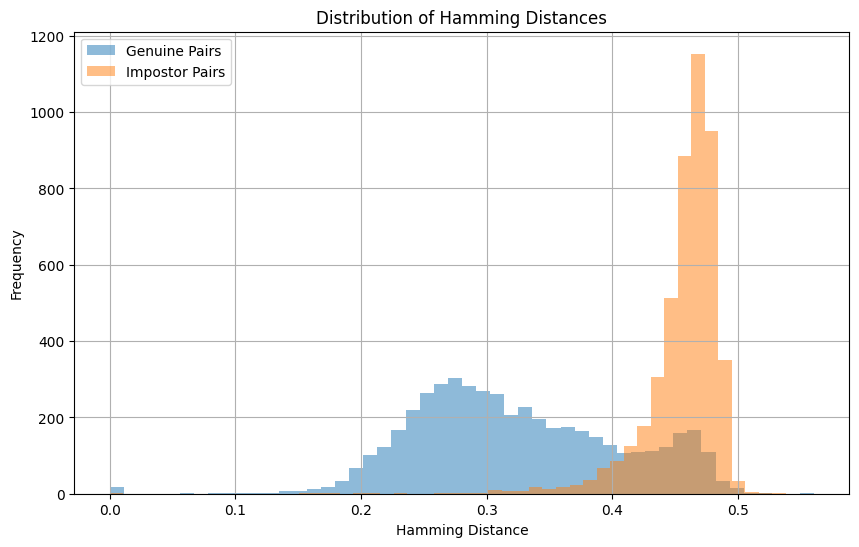

In [39]:
test(all_filenames, structured_data)